In [1]:
import numpy as np
import scipy.constants as const
import matplotlib.pyplot as plt
import math
from scipy.integrate import quad
from constants import *

In [6]:
mu=1.16294E-26 # N2 reduced mass
wavenumber_per_eV = 8065.6

In [7]:
def Gv(v, we, wexe, weye, weze=0, weae=0):
    "Vibrational energy level"
    return we*(v+1/2) - wexe*(v+1/2)**2 + weye*(v+1/2)**3 + weze*(v+1/2)**4 + weae*(v+1/2)**5

def Te(v, T0, we, wexe, weye, weze=0, weae=0):
    "Energy at minimum of well"
    return T0 - we/2 + wexe/4 - weye/8 - weze/16 - weae/32

def Tv(v, T0, we, wexe, weye, weze=0, weae=0):
    "Energy difference from minimum to vibrational energy level"
    return Te(v, T0, we, wexe, weye, weze, weae) + Gv(v, we, wexe, weye, weze, weae)

def Bv(v, Be, ae, ge=0, de=0, ee=0):
    "Rotational energy level"
    return Be - ae*(v+1/2) - ge*(v+1/2)**2 + de*(v+1/2)**3 + ee*(v+1/2)**4

def fIntegrand(vp, v, vibConstants):
    "Integrand of Gilmore et al (1992) eqn 1"
    (T0, we, wexe, weye, weze, weae) = vibConstants
    return 1/math.sqrt(Gv(v,we,wexe,weye,weze)-Gv(vp,we,wexe,weye,weze))

def gIntegrand(vp, v, vibConstants, rotConstants):
    "Integrand of Gilmore et al (1992) eqn 2"
    (T0, we, wexe, weye, weze, weae) = vibConstants
    (Be, ae, ge, de, ee) = rotConstants
    return Bv(v,Be,ae,ge)/math.sqrt(Gv(v,we,wexe,weye,weze)-Gv(vp,we,wexe,weye,weze))

In [9]:
def f(v, vibConstants):
    "Gilmore et al (1992) eqn 1"
    I = quad(fIntegrand,-1/2,v,args=(v, vibConstants), full_output=True, epsabs=1.0E-16, limit=24)
    return 1/(2*const.pi*math.sqrt(2*mu*const.speed_of_light/const.Planck)) * I[0] * 1E8

def g(v, vibConstants, rotConstants):
    "Gilmore et al (1992) eqn 2"
    I = quad(gIntegrand,-1/2,v,args=(v, vibConstants, rotConstants), epsabs=1.0E-16, limit=24)
    return 2*const.pi*math.sqrt(2*mu*const.speed_of_light/const.Planck) * I[0] * 1E-8

In [10]:
def r(v, vibConstants, rotConstants):
    "Compute r_inner and r_outer from Gilmore et al (1992) eqn 3"
    fv=f(v, vibConstants)
    gv=g(v, vibConstants, rotConstants)
    return [math.sqrt(fv**2 + fv/gv)-fv, math.sqrt(fv**2 + fv/gv)+fv]

In [11]:
def compute_pes(state, vib_constants, rot_constants, vmax=3):
    """compute vmax*2 points on a potential energy surface defined by
    vibrational constants (vib_constants) and rotational constants (rot_constants)
    for state 'state'
    
    Arguments
    ---------
    state : int
        the array index of the vib_contants and rot_contants arrays indicating
        which state is to be computed
        
    vib_/rot_constants : list
        list of vibrational and rotational constants from constants.py
        
    vmax : int
        max vibrational mode of interest; vmax * 2 points will be calculated
        (r_inner's and r_outer's)
        
    Returns
    -------
    pes : numpy.array
        points on the PES (r, Tv)
    """
    pes = []
    
    (T0, we, wexe, weye, weze, weae) = vib_constants[state]
    
    for vp in range(vmax+1):
        rvp=r(vp, vib_constants[state], rot_constants[state])
        Tvp=Tv(vp, T0, we, wexe, weye, weze, weae)/wavenumber_per_eV
        pes.insert(0, [rvp[0], Tvp])
        pes.append([rvp[1], Tvp])
    
    pes = np.asarray(pes)
                
    return pes

In [12]:
X1Sigmagp_pes = compute_pes(0, vib_constants_N2, rot_constants_N2, vmax=9)
A3Sigmaup_pes = compute_pes(1, vib_constants_N2, rot_constants_N2, vmax=9)

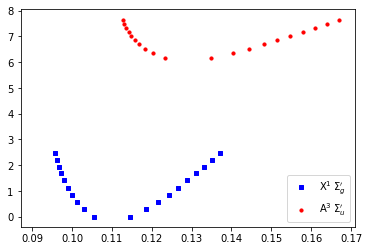

In [16]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

x,y = X1Sigmagp_pes.T
ax1.scatter(x, y, s=10, c='b', marker="s", label='X${}^1\;\Sigma_g^\prime$')
x,y = A3Sigmaup_pes.T
ax1.scatter(x,y, s=10, c='r', marker="o", label='A${}^3\;\Sigma_u^\prime$')
plt.legend(loc='lower right');
plt.show()